In [1]:
import pandas as pd

In [2]:
data = pd.read_excel( r'C:\Users\ss4432\TFR\hydrus1.xlsx')

In [3]:
data

,Time,ItW,ItCum,vTop,SvTop,SvRoot,SvBot,hTop,hRoot,hBot
0,90.1000,2,2,2.400000e-07,2.400000e-08,0.016,-0.0038,-55.4,-37,175
1,90.2286,2,4,-1.300000e-06,-1.400000e-07,0.037,-0.0087,-55.8,-38,174
2,90.3829,2,6,-4.300000e-07,-2.100000e-07,0.061,-0.0140,-56.3,-38,174
3,90.5886,2,8,8.100000e-07,-4.500000e-08,0.094,-0.0220,-56.9,-39,173
4,91.0000,2,10,-1.100000e-08,-4.900000e-08,0.160,-0.0370,-58.2,-40,172
...,...,...,...,...,...,...,...,...,...,...
85,280.0000,2,172,1.530000e-02,-1.600000e+00,11.300,-1.2000,-71.5,33,262
86,285.0000,2,174,1.610000e-02,-1.600000e+00,11.600,-1.2000,-71.5,33,263
87,290.0000,2,176,1.690000e-02,-1.600000e+00,11.900,-1.2000,-71.5,32,263
88,295.0000,2,178,1.780000e-02,-1.600000e+00,12.200,-1.3000,-71.5,32,264


In [4]:
import matplotlib.pyplot as plt

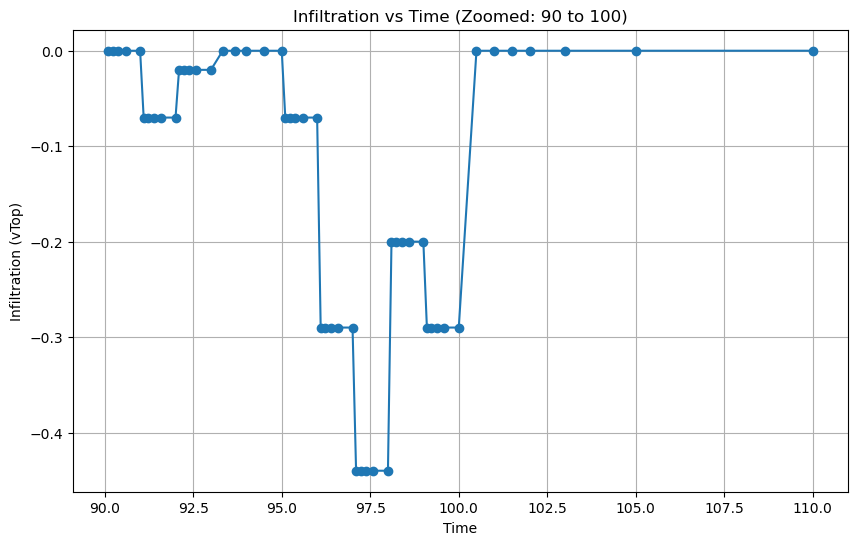

In [5]:
zoomed_data = data[(data['Time'] >= 90) & (data['Time'] <= 110)]
plt.figure(figsize=(10, 6))
plt.plot(zoomed_data['Time'], zoomed_data['vTop'], marker='o', linestyle='-')
plt.title('Infiltration vs Time (Zoomed: 90 to 100)')
plt.xlabel('Time')
plt.ylabel('Infiltration (vTop)')
plt.grid(True)
plt.show()

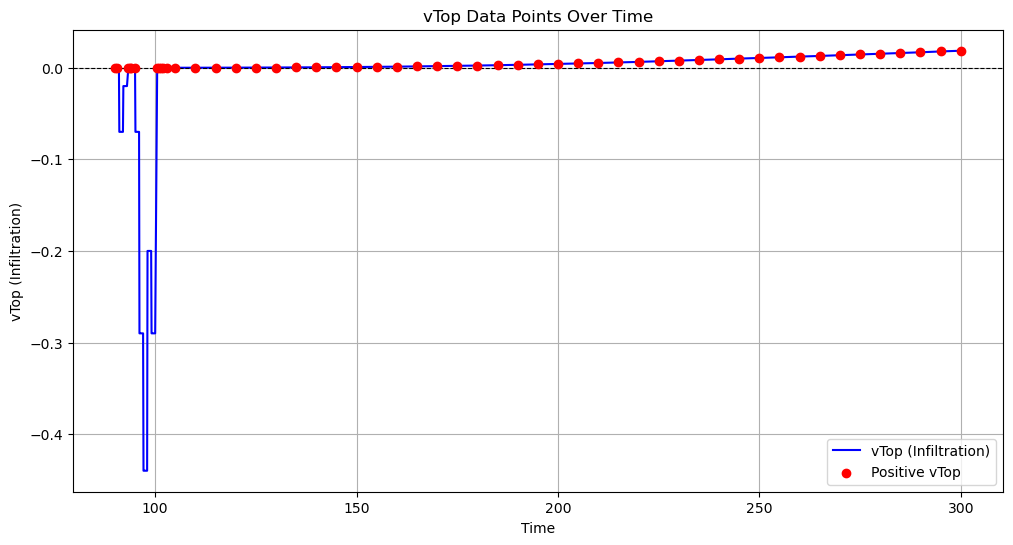

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['vTop'], label='vTop (Infiltration)', color='blue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')


# Highlighting positive values
positive_values = data['vTop'] > 0
plt.scatter(data['Time'][positive_values], data['vTop'][positive_values], color='red', label='Positive vTop', zorder=5)

plt.xlabel('Time')
plt.ylabel('vTop (Infiltration)')
plt.title('vTop Data Points Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
data['Precipitation'] = data['vTop'] + data['SvRoot']

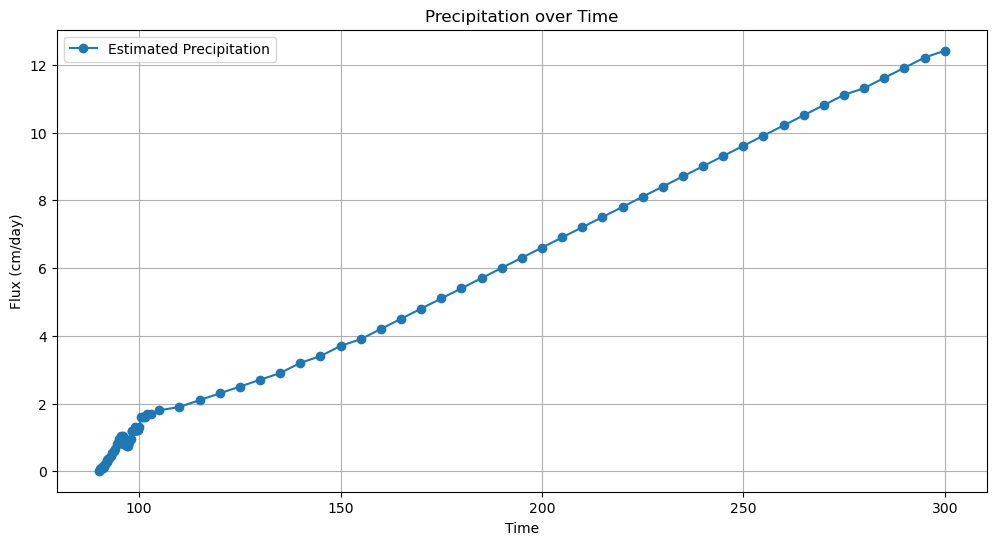

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Precipitation'], marker='o', linestyle='-', label='Estimated Precipitation')
#plt.plot(data['Time'], data['vTop'], marker='o', linestyle='-', label='Infiltration (vTop)')
#plt.plot(data['Time'], data['SvRoot'], marker='o', linestyle='-', label='Root Water Uptake (SvRoot)')
plt.title('Precipitation over Time')
plt.xlabel('Time')
plt.ylabel('Flux (cm/day)')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import numpy as np
time = data['Time']
#only negative values are taken
infiltration_data = np.where(data['vTop']<0, data['vTop'], 0)

precipitation = data['vTop'] + data['SvRoot']


Nx = 50
Ny = 50
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x,y)
zb = np.zeros_like(X)
zb += (X - 0.5) * 15  
zb += (Y > 0.5) * (X - 0.7)**2 * 10  
zb -= (Y <= 0.5) * (X - 0.3)**2 * 5  
zb += (X > 0.7) * 2  

initial_depth = 0.2  
dzb_dx = np.gradient(zb, axis=0)  
dzb_dy = np.gradient(zb, axis=1)  
slope_x = -dzb_dx
slope_y = -dzb_dy
n = 0.04  
g = 9.81  
dt = 0.001  
dx = 1.0  
dy = 1.0  
time_start = 90  
time_end = 273  
h = np.full((Nx, Ny), initial_depth)  
qx = np.zeros((Nx, Ny))  
qy = np.zeros((Nx, Ny)) 




In [26]:
runoff=[]

# switching for boundary condition is done by heaviside function based on water depth 
omega = 0.01

def eta(h):
    return np.where(h >=0,1,0)
def eta_omega(h,omega):
    return (1/np.pi)* np.arctan(h/omega) + 0.5 

In [27]:
CFL = 0.9
def F(U):
    h,qx,qy = U
    u = qx/h
    v = qy/h
    return np.array([qx,qx*u+0.5*g*h**2,qx*v])

def G(U):
    h, qx, qy = U
    u = qx / h
    v = qy / h
    return np.array([qy, qy*u, qy*v + 0.5*g*h**2])

def compute_source_term(h,qx,qy,slope_x,slope_y,n):
    u = qx/h
    v = qy/h
    velocity_magnitude = np.sqrt(u**2+v**2)
    Sf_x = n**2*u*velocity_magnitude/h**(4/3)
    Sf_y = n**2*v*velocity_magnitude/h**(4/3)
    S1 = eta_omega(h_ij,omega)*(precipitation[t_index] - infiltration_data[t_index])
    S2 = g*h*(slope_x - Sf_x)
    S3 = g*h*(slope_x - Sf_x)
    return S1,S2,S3
def roe_solver(U_left,U_right,n_x,n_y):
    hL,qxL,qyL = U_left
    hR,qxR,qyR = U_right
    uL,vL = qxL/hL,qyL/hL
    uR,vR = qxR/hR,qyR/hR
    sqrt_hL = np.sqrt(hL)
    sqrt_hR = np.sqrt(hR)
    h_t = sqrt_hL*sqrt_hR
    u_t = (sqrt_hL * uL + sqrt_hR * uR) / (sqrt_hL + sqrt_hR)
    v_t = (sqrt_hL * vL + sqrt_hR * vR) / (sqrt_hL + sqrt_hR)
    c_t = np.sqrt(g * h_t)
    n_dot_u_t = u_t*n_x + v_t*n_y

    #eigenvalue
    lambda_1 = n_dot_u_t - c_t
    lambda_2 = n_dot_u_t
    lambda_3 = n_dot_u_t + c_t

    #eigenvector
    epsilon1 = np.array([1, n_x * (u_t - c_t), n_y * (v_t - c_t)])
    epsilon2 = np.array([0, -n_y, n_x])
    epsilon3 = np.array([1, n_x * (u_t + c_t), n_y * (v_t + c_t)])
    
    delta_U = U_right - U_left
    delta_h = delta_U[0]
    delta_qx = delta_U[1]
    delta_qy = delta_U[2]

    alpha1 = (delta_h - delta_qx / (2 * c_t) - delta_qy / (2 * c_t))
    alpha2 = (-n_y * delta_qx + n_x * delta_qy)
    alpha3 = (delta_h + delta_qx / (2 * c_t) + delta_qy / (2 * c_t))

    F_Roe = 0.5 * (F(U_left) + F(U_right)) - 0.5 * (alpha1 * np.abs(lambda_1) * epsilon1 +
                                                    alpha2 * np.abs(lambda_2) * epsilon2 +
                                                    alpha3 * np.abs(lambda_3) * epsilon3)
    return F_Roe


In [12]:

runoff = []
average_h = []
average_qx = []
average_qy = []
average_friction_x = []
average_friction_y = []


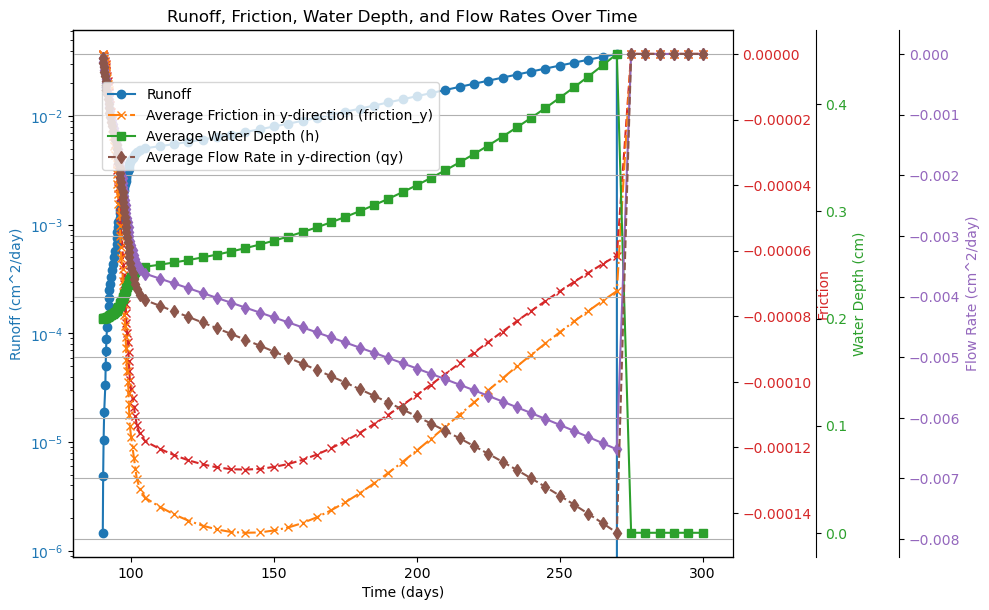

In [13]:
for t_index in range(len(time)):
    t=time[t_index]
    if time_start <= t <= time_end:
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                h_ij = h[i,j]
                qx_ij = qx[i,j]
                qy_ij = qy[i,j]
                U = np.array([h[i, j], qx[i, j], qy[i, j]])
                S = np.array(compute_source_term(h[i, j], qx[i, j], qy[i, j], slope_x[i, j], slope_y[i, j], n))
                flux_diff = np.zeros(3)
                #Flux computation
                for (di, dj, n_x, n_y) in [(-1, 0, -1, 0), (1, 0, 1, 0), (0, -1, 0, -1), (0, 1, 0, 1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < Nx and 0 <= nj < Ny:
                        U_next = np.array([h[ni, nj], qx[ni, nj], qy[ni, nj]])
                        F_upwind = roe_solver(U, U_next, n_x, n_y)
                        flux_diff -= F_upwind * (n_x * dx + n_y * dy)
                U_new = U + dt * (flux_diff / dx + S)
                h[i, j], qx[i, j], qy[i, j] = U_new

        qx[0, :] = qx[1, :]   
        qx[-1, :] = qx[-2, :] 
        h[0, :] = h[1, :]
        h[-1, :] = h[-2, :]
        qy[:, 0] = qy[:, 1]   
        qy[:, -1] = qy[:, -2] 
        h[:, 0] = h[:, 1]
        h[:, -1] = h[:, -2]

        runoff.append(np.sum(qx[-2, :]))
        u = qx/h
        v = qy/h
        velocity_magnitude = np.sqrt(u**2+v**2)
        # Calculate and store average values
        avg_h = np.mean(h)
        avg_qx = np.mean(qx)
        avg_qy = np.mean(qy)
        avg_friction_x = np.mean(n**2*u*velocity_magnitude/h**(4/3))
        avg_friction_y = np.mean(n**2*v*velocity_magnitude/h**(4/3))
        
        average_h.append(avg_h)
        average_qx.append(avg_qx)
        average_qy.append(avg_qy)
        average_friction_x.append(avg_friction_x)
        average_friction_y.append(avg_friction_y)
    else:
        # Append zero values if out of simulation bounds
        runoff.append(0)
        average_h.append(0)
        average_qx.append(0)
        average_qy.append(0)
        average_friction_x.append(0)
        average_friction_y.append(0)

# Ensure arrays match the length of the time array
if len(runoff) < len(time):
    runoff.extend([0] * (len(time) - len(runoff)))
    average_h.extend([0] * (len(time) - len(average_h)))
    average_qx.extend([0] * (len(time) - len(average_qx)))
    average_qy.extend([0] * (len(time) - len(average_qy)))
    average_friction_x.extend([0] * (len(time) - len(average_friction_x)))
    average_friction_y.extend([0] * (len(time) - len(average_friction_y)))

# Plot runoff, friction, water depth, and flow rates in one graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot runoff
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Runoff (cm^2/day)', color='tab:blue')
ax1.plot(time, runoff, marker='o', linestyle='-', color='tab:blue', label='Runoff')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_yscale('log')

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()
ax2.set_ylabel('Friction', color='tab:red')
ax2.plot(time, average_friction_x, marker='x', linestyle='--', color='tab:red')
ax2.plot(time, average_friction_y, marker='x', linestyle='-.', color='tab:orange', label='Average Friction in y-direction (friction_y)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Create another twin Axes sharing the same x-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.set_ylabel('Water Depth (cm)', color='tab:green')
ax3.plot(time, average_h, marker='s', linestyle='-', color='tab:green', label='Average Water Depth (h)')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Create another twin Axes sharing the same x-axis for flow rates
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth axis
ax4.set_ylabel('Flow Rate (cm^2/day)', color='tab:purple')
ax4.plot(time, average_qx, marker='d', linestyle='-', color='tab:purple' )
ax4.plot(time, average_qy, marker='d', linestyle='--', color='tab:brown', label='Average Flow Rate in y-direction (qy)')
ax4.tick_params(axis='y', labelcolor='tab:purple')

# Add legend
fig.tight_layout()  # Adjust layout to prevent overlap
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.title('Runoff, Friction, Water Depth, and Flow Rates Over Time')
plt.grid(True)
plt.show()
    #else:
       # runoff.append(0)


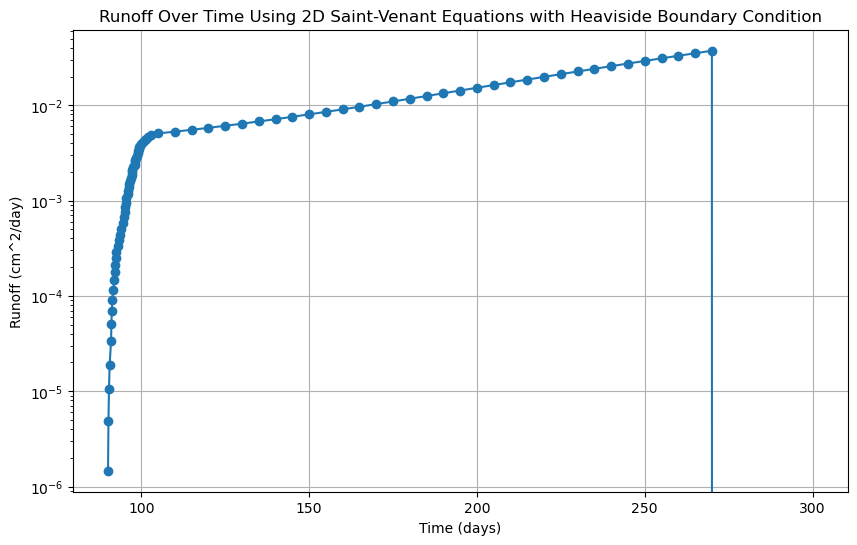

In [14]:
# Ensure runoff array matches the length of the time array
if len(runoff) < len(time):
    runoff.extend([0] * (len(time) - len(runoff)))


plt.figure(figsize=(10, 6))
plt.plot(time, runoff, marker='o', linestyle='-')
plt.xlabel('Time (days)')
plt.ylabel('Runoff (cm^2/day)')
plt.title('Runoff Over Time Using 2D Saint-Venant Equations with Heaviside Boundary Condition')
plt.grid(True)
plt.yscale('log') 
plt.show()


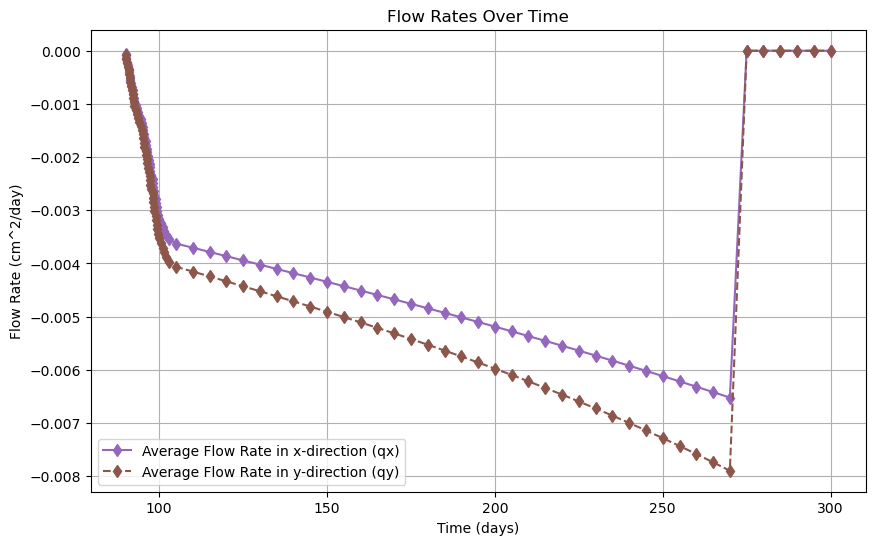

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(time, average_qx, marker='d', linestyle='-', color='tab:purple', label='Average Flow Rate in x-direction (qx)')
plt.plot(time, average_qy, marker='d', linestyle='--', color='tab:brown', label='Average Flow Rate in y-direction (qy)')
plt.xlabel('Time (days)')
plt.ylabel('Flow Rate (cm^2/day)')
plt.title('Flow Rates Over Time')
plt.legend()
plt.grid(True)
plt.show()


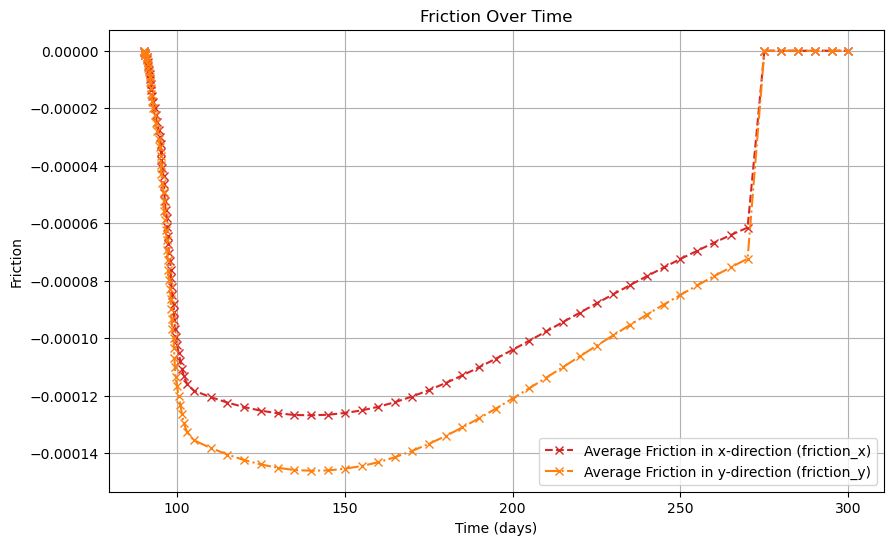

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(time, average_friction_x, marker='x', linestyle='--', color='tab:red', label='Average Friction in x-direction (friction_x)')
plt.plot(time, average_friction_y, marker='x', linestyle='-.', color='tab:orange', label='Average Friction in y-direction (friction_y)')
plt.xlabel('Time (days)')
plt.ylabel('Friction')
plt.title('Friction Over Time')
plt.legend()
plt.grid(True)
plt.show()


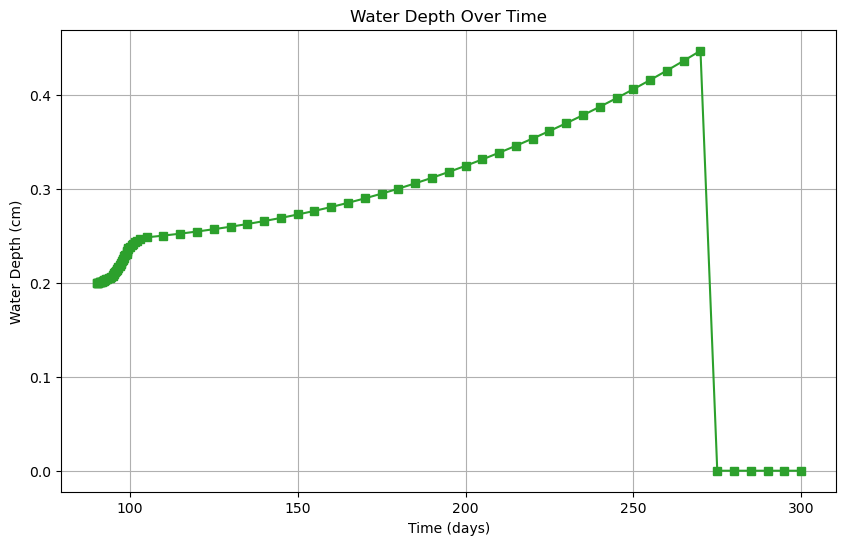

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(time, average_h, marker='s', linestyle='-', color='tab:green')
plt.xlabel('Time (days)')
plt.ylabel('Water Depth (cm)')
plt.title('Water Depth Over Time')
plt.grid(True)
plt.show()


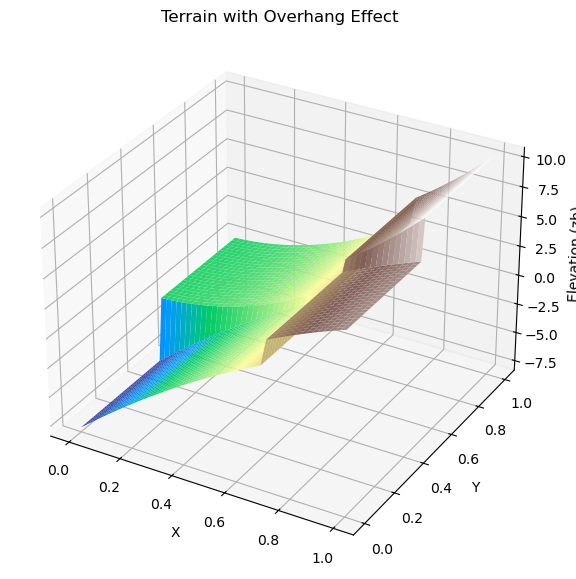

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid
Nx, Ny = 50, 50
X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))

# Initialize zb
zb = np.zeros_like(X)
zb += (X - 0.5) * 15  # Overall slope
zb += (Y > 0.5) * (X - 0.7)**2 * 10  # Gully effect
zb -= (Y <= 0.5) * (X - 0.3)**2 * 5  # Overhang effect
zb += (X > 0.7) * 2  # Additional elevation change

# Plot the terrain
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, zb, cmap='terrain', edgecolor='none')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Elevation (zb)')
ax.set_title('Terrain with Overhang Effect')

plt.show()


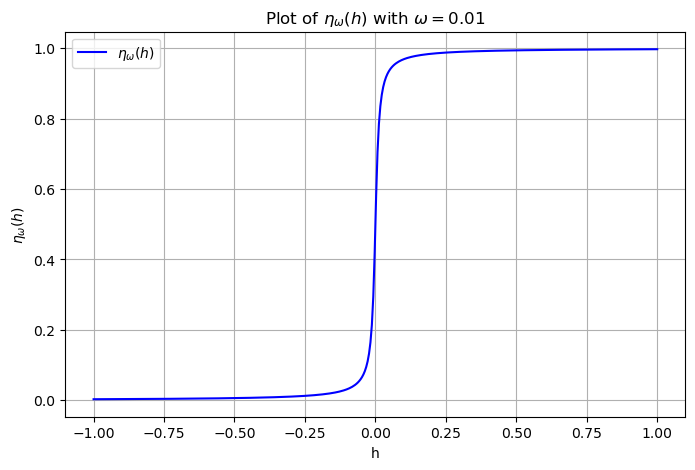

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function eta_omega
def eta_omega(h, omega):
    return (1/np.pi) * np.arctan(h / omega) + 0.5

# Define a range of h values and omega
h_values = np.linspace(-1, 1, 400)  # Range of h values
omega = 0.01  # Smoothing parameter

# Compute eta_omega for these h values
eta_omega_values = eta_omega(h_values, omega)

# Plot the eta_omega function
plt.figure(figsize=(8, 5))
plt.plot(h_values, eta_omega_values, label=r'$\eta_\omega(h)$', color='blue')
plt.xlabel('h')
plt.ylabel(r'$\eta_\omega(h)$')
plt.title(r'Plot of $\eta_\omega(h)$ with $\omega = 0.01$')
plt.grid(True)
plt.legend()
plt.show()
